### Load libraries

In [1]:
import pathlib

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.special
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)

### Load data

In [2]:
# Check if file exists:
if (GIT_ROOT / "data/clip-embeddings/CIFAR100_clip.npz").exists():
    d = np.load(GIT_ROOT / "data/clip-embeddings/CIFAR100_clip.npz")
else:
    d = np.load("/home/gridsan/groups/ccg/data/scaling/clip-embeddings/CIFAR100_clip.npz")

XS_TRAIN, YS_TRAIN = d["xs_train"], d["ys_train"]
XS_TEST, YS_TEST = d["xs_test"], d["ys_test"]
XS_TRAIN.shape, XS_TEST.shape
total_num_classes = np.unique(YS_TRAIN).shape[0]
total_num_classes

100

### Experiment code

In [3]:
def get_min_xent(probs: np.ndarray, labs: np.ndarray) -> float:
    logits = np.log(probs)

    def get_xent(alpha: float) -> float:
        tlogits = logits * alpha
        tprobs = scipy.special.softmax(tlogits, axis=1)
        return -np.log(tprobs[np.arange(len(tprobs)), labs]).mean()

    res = scipy.optimize.minimize_scalar(get_xent, bounds=(0.01, 100))
    return res.fun

def run_experiment(
    n_train: int,
    n_classes: int,
    C: float,
    max_iter: int,
    seed: int = 0,
    debug: bool = False,
):
    param_dict = {
        "n_train": n_train,
        "n_classes": n_classes,
        "C": C,
        "max_iter": max_iter,
        "seed": seed,
    }

    # Get first n_classes classes
    classes = np.arange(n_classes)

    # Subset train data to chosen classes.
    mask_train = np.isin(YS_TRAIN, classes)
    xs_train = XS_TRAIN[mask_train]
    ys_train = YS_TRAIN[mask_train]

    # Subset test data to chosen classes.
    mask_test = np.isin(YS_TEST, classes)
    xs_test = XS_TEST[mask_test]
    ys_test = YS_TEST[mask_test]

    # Possibly reduce n_train if there are not enough train samples.
    n_train = min(n_train, len(xs_train))

    # Subset train data to size n_train
    idx = np.random.choice(len(xs_train), n_train, replace=False)
    xs_train = xs_train[idx]
    ys_train = ys_train[idx]

    # Handle case where we only have one class
    if ys_train.min() == ys_train.max():
        acc = (ys_test == ys_train[0]).mean()
        return param_dict | {"acc": acc, "xent": np.infty}

    # Train a logistic regression classifier on the training data
    clf = LogisticRegression(
        random_state=seed,
        max_iter=max_iter,
        multi_class="multinomial",
        **({"C": C, "penalty": "l2"} if C > 0 else {"penalty": "none"}),
    )
    clf.fit(xs_train, ys_train)

    # Evaluate the classifier on the test data
    acc = clf.score(xs_test, ys_test)

    # Compute cross-entropy loss on the test data
    ys_test_reordered = ys_test.copy()
    for i, cls in enumerate(clf.classes_):
        ys_test_reordered[ys_test == cls] = i

    xent = get_min_xent(
        clf.predict_proba(xs_test),
        ys_test_reordered
    ) if np.isin(ys_test, clf.classes_).all() else np.infty

    ret_dict = param_dict | {"acc": acc, "xent": xent}
    if debug:
        ret_dict["probs"] = clf.predict_proba(xs_test)
        ret_dict["ys_test_reordered"] = ys_test_reordered

    return ret_dict

### Collect scaling data

In [4]:
DATA = []

In [5]:
for n_train in tqdm(list(range(1, 16)) + [32, 64, 100, 500, 1000]):
    for C in [0.01, 1, 100]:
        for seed in range(10):
            # for n_classes in [2, 5, 10]:
            for n_classes in [total_num_classes/5, total_num_classes/2, total_num_classes]:
                DATA.append(
                    run_experiment(
                        n_train=n_train,
                        n_classes=n_classes,
                        C=C,
                        max_iter=10000,
                        seed=seed,
                    )
                )

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
for n_train in tqdm([5000, 10000, 50000]):
    for C in [0.01]:
        for seed in range(3):
            for n_classes in [total_num_classes/5, total_num_classes/2, total_num_classes]:
                with np.errstate(divide='ignore'):
                    DATA.append(
                        run_experiment(
                            n_train=n_train,
                            n_classes=n_classes,
                            C=C,
                            max_iter=10000,
                            seed=seed,
                        )
                    )

  0%|          | 0/3 [00:00<?, ?it/s]

# Analyze data

In [7]:
df = pd.DataFrame(DATA)
# df = pd.read_csv("clip-cifar-scaling.csv")
df["err"] = 1 - df.acc

# Merge old data in
# old_df = pd.read_csv("clip-cifar-scaling.csv")
# df = pd.concat([old_df, df], ignore_index=True)
df

,n_train,n_classes,C,max_iter,seed,acc,xent,err
0,1,20.0,0.01,10000,0,0.0500,inf,0.9500
1,1,50.0,0.01,10000,0,0.0200,inf,0.9800
2,1,100.0,0.01,10000,0,0.0100,inf,0.9900
3,1,20.0,0.01,10000,1,0.0500,inf,0.9500
4,1,50.0,0.01,10000,1,0.0200,inf,0.9800
...,...,...,...,...,...,...,...,...
1822,50000,50.0,0.01,10000,1,0.9136,0.290736,0.0864
1823,50000,100.0,0.01,10000,1,0.8667,0.452625,0.1333
1824,50000,20.0,0.01,10000,2,0.9550,0.142074,0.0450
1825,50000,50.0,0.01,10000,2,0.9136,0.290709,0.0864


In [6]:
# df.to_csv("clip-cifar-scaling.csv", index=False)

### CLIP scaling

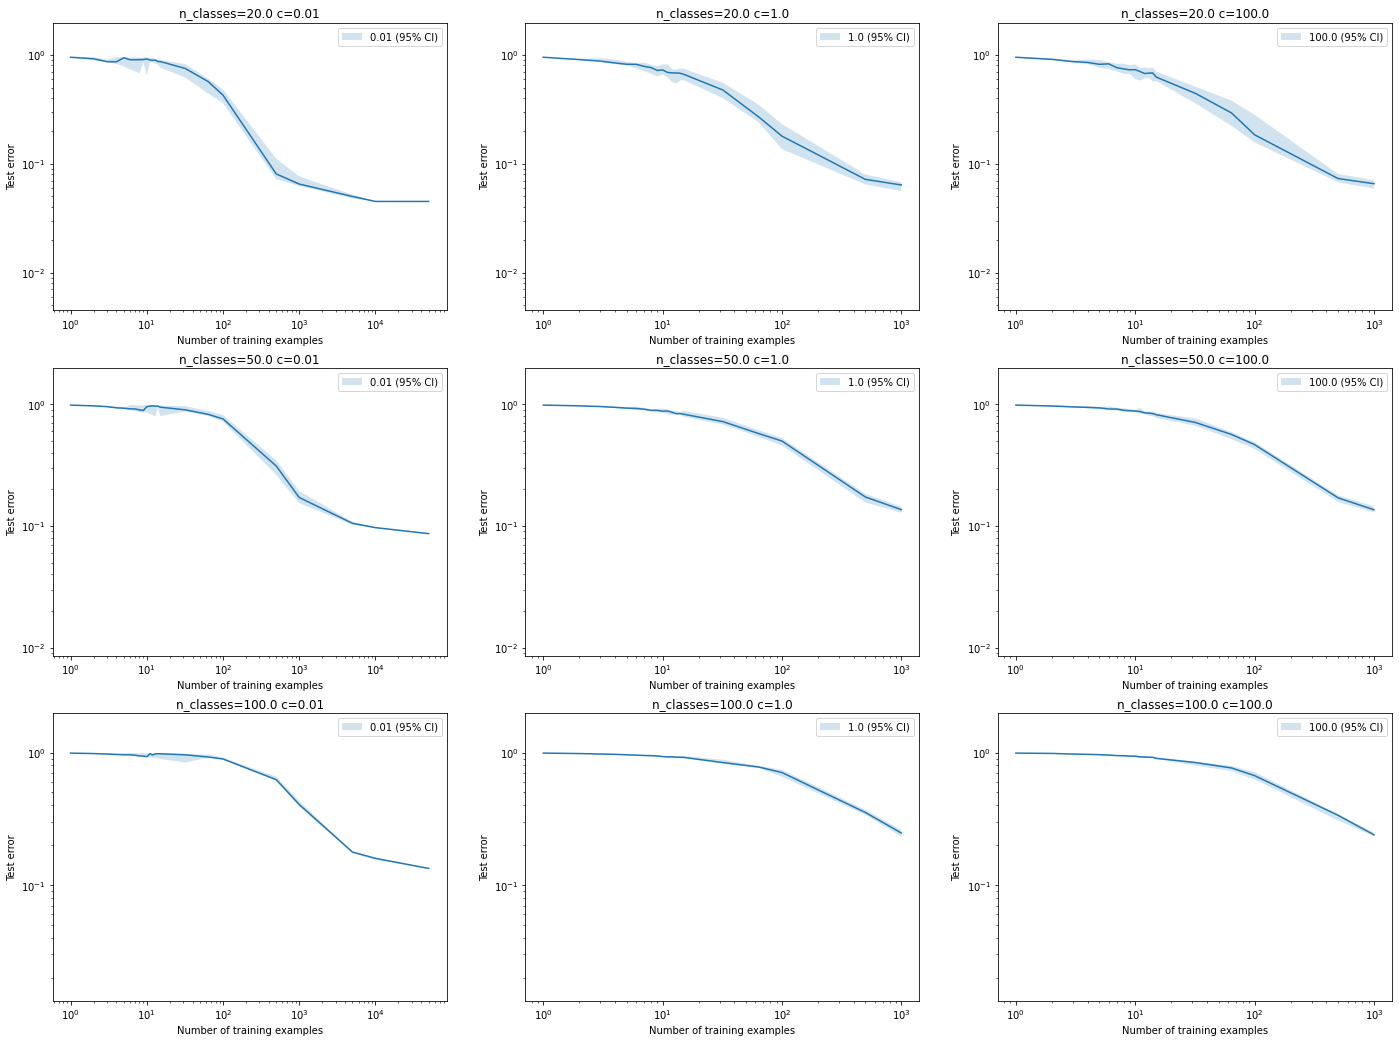

In [15]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).err
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"{c} (95% CI)"
        )

        plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").err.min(), 2 * df.err.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        # plt.yscale("symlog", linthresh=1e-4)
        plt.yscale("log")
        plt.xlabel("Number of training examples")
        plt.ylabel("Test error")

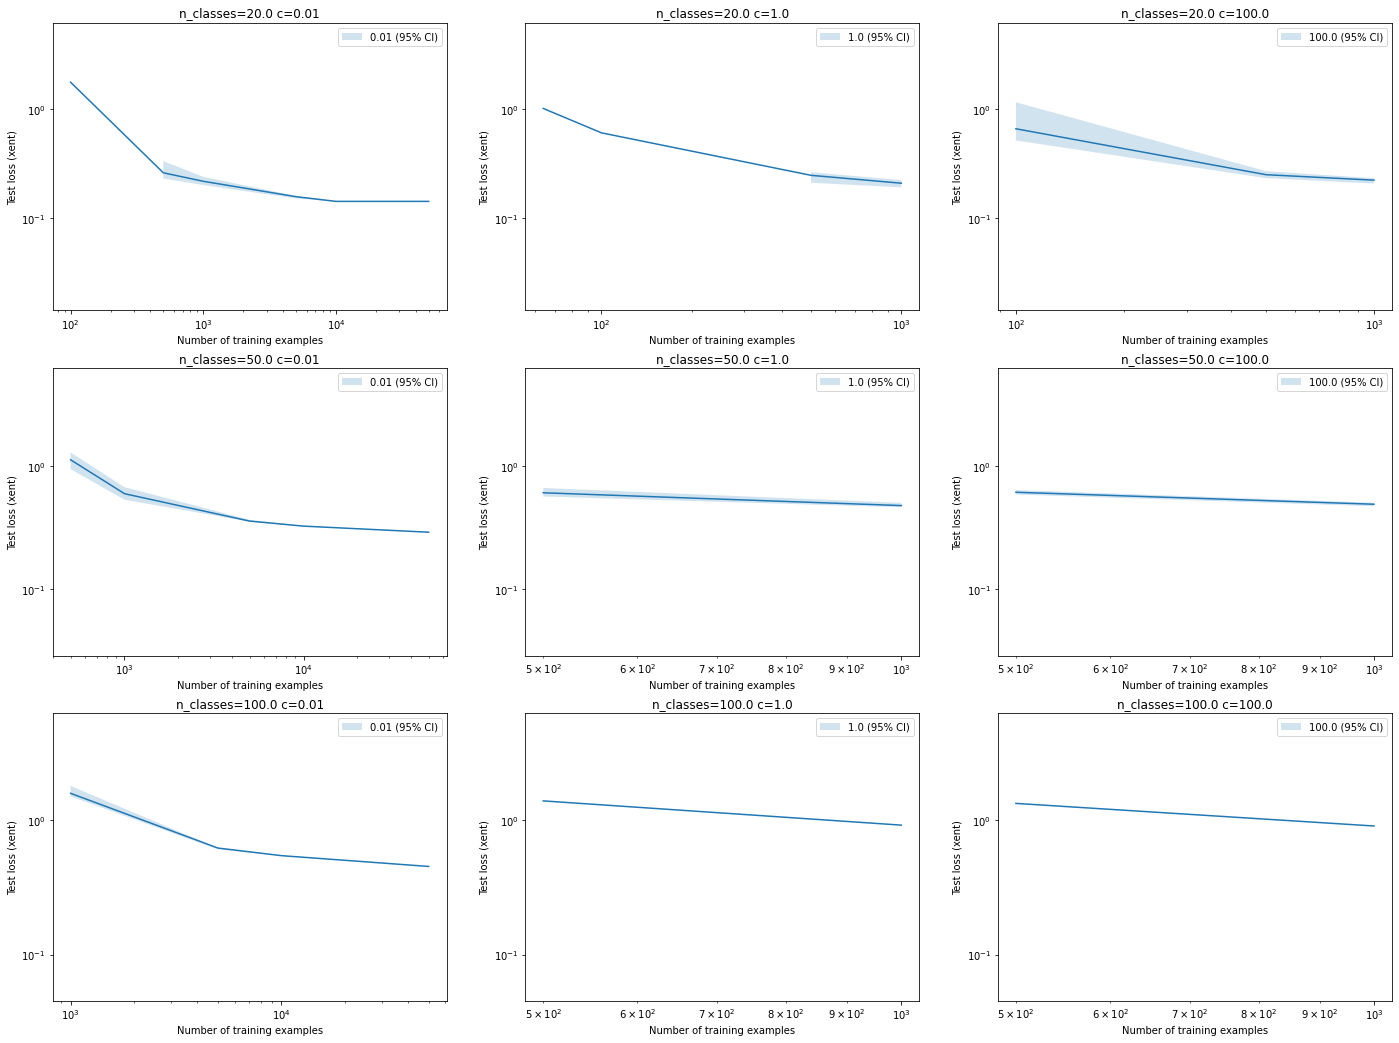

In [9]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).xent
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"{c} (95% CI)"
        )

        with pd.option_context('mode.use_inf_as_na', True):
            plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").xent.min(), 2 * df.dropna().xent.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        plt.yscale("symlog", linthresh=1e-4)
        plt.xlabel("Number of training examples")
        plt.ylabel("Test loss (xent)")

One thing to note about the above plots: The last three points are only single samples and do not have error bars!

### CLIP vs natural scaling

In [11]:
df_bahri = pd.read_csv(GIT_ROOT / "data/bahri-cifar100/wpd_clean_CIFAR100.csv")
df_bahri.tail()

,n_train,err,xent
9,20000,0.274295,1.097182
10,30000,0.232349,0.929397
11,32768,0.221280,0.876520
12,40000,0.206663,0.826652
13,50000,0.183816,0.728123


In [10]:
# df_prune_scratch = pd.read_csv(GIT_ROOT / "data/sorscher-cifar100/scratch/wpd-clean.csv")
# df_prune_scratch["err"] = df_prune_scratch.errp / 100
# df_prune_scratch.tail()

,n_train,errp,err
13,10204.034771,8.564766,0.085648
14,12200.279230,7.033175,0.070332
15,19825.925427,5.522567,0.055226
16,24835.575267,4.606628,0.046066
17,29809.793966,4.514735,0.045147


In [11]:
# df_prune_transfer = pd.read_csv(GIT_ROOT / "data/sorscher-cifar100/transfer/wpd-clean.csv")
# df_prune_transfer.tail()

,n_train,err
9,2384.730091,0.024559
10,3409.498972,0.019425
11,4992.200101,0.015317
12,6969.365290,0.014589
13,9964.248735,0.013234


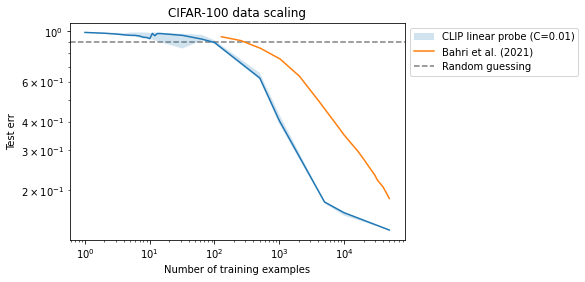

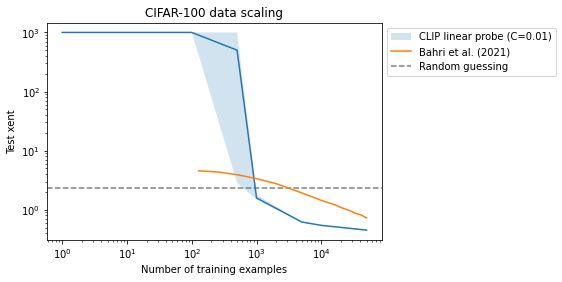

In [14]:
for metric in ["err", "xent"]:
    C = 0.01
    gb = (
        df.replace(np.infty, 1e3)
        .query(f"n_classes == 100 & C == {C}")
        .groupby("n_train")[metric]
    )
    lo = gb.min()
    mid = gb.median()
    hi = gb.max()

    plt.plot(mid.index, mid)
    plt.fill_between(
        mid.index, lo, hi, alpha=0.2, label=f"CLIP linear probe ({C=})"
    )

    plt.plot(df_bahri.n_train, df_bahri[metric], label="Bahri et al. (2021)")

    # if metric == "err":
    #     plt.plot(df_prune_scratch.n_train, df_prune_scratch[metric], label="Pruning paper (from scratch)")
    #     plt.plot(df_prune_transfer.n_train, df_prune_transfer[metric], label="Pruning paper (transfer)")

    plt.axhline(
        0.9 if metric == "err" else -np.log(0.1),
        color="k",
        linestyle="--",
        label="Random guessing",
        zorder=-10,
        alpha=0.5,
    )

    plt.title(f"CIFAR-100 data scaling")
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Number of training examples")
    plt.ylabel(f"Test {metric}")

    # Plot legend on top right of figure
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()


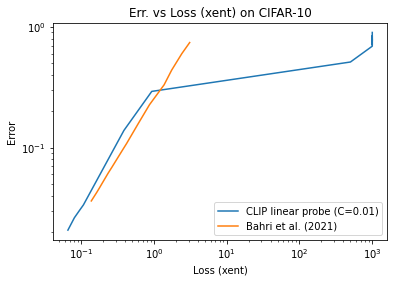

In [13]:
C = 0.01
gb = (
    df.replace(np.infty, 1e3)
    .query(f"n_classes == 10 & C == {C}")
    .groupby("n_train")
)
mid_err = gb.err.median()
mid_xent = gb.xent.median()

plt.plot(mid_xent, mid_err, label=f"CLIP linear probe ({C=})")
plt.plot(df_bahri.xent, df_bahri.err, label="Bahri et al. (2021)")

plt.title(f"Err. vs Loss (xent) on CIFAR-10")

plt.xscale("log")
plt.yscale("log")
plt.ylabel("Error")
plt.xlabel(f"Loss (xent)")
plt.legend();